<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/priors/extrapolate_lattice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sandbox to try out lattice based models

### Lattice based models

* allow you to actively encode domain knowledge into the learning process
* specify constraints such as monotonicity
* constraints are specified as lattices overlaying the learning process
* lattices are a way to specify constraints
* additional regularization can be added to the lattices
* domain knowledge to better extrapolate to the parts of the input space not covered by the training dataset
* avoid unexpected model behavior when the serving distribution is different from the training distribution

### Links
* https://www.tensorflow.org/lattice
* https://blog.tensorflow.org/2020/02/tensorflow-lattice-flexible-controlled-and-interpretable-ML.html
* https://www.tensorflow.org/lattice/tutorials/premade_models
* https://github.com/tensorflow/lattice
* https://jmlr.org/papers/v17/15-243.html

# Installation

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
tf.random.set_seed(42)

In [3]:
import numpy as np
np.random.seed(42)

np.__version__

'1.21.6'

In [4]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
# https://www.tensorflow.org/lattice/install

!pip install -q --upgrade tensorflow-lattice

In [6]:
import tensorflow_lattice as tfl

In [7]:
import numpy as np
np.__version__

'1.21.6'

In [8]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/RSquare
!pip install -q tensorflow-addons

In [9]:
import tensorflow_addons as tfa
tfa.__version__

'0.17.0'

In [10]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [11]:
from lrcurve import KerasLearningCurve

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

# Sample Application: Predicting beer consumption

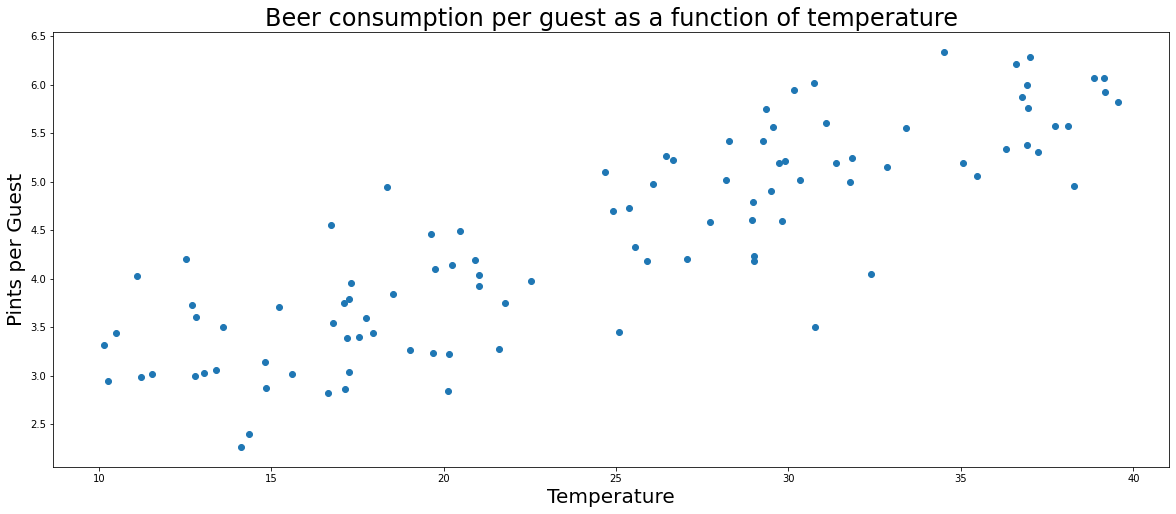

In [13]:
n = 100
m = .1
b = 2

noise_level = .6
noise = np.random.normal(0, noise_level, n)

title = 'Beer consumption per guest as a function of temperature'
x_label = 'Temperature'
y_label = 'Pints per Guest'

# sort is not necessary, but makes x easier to understand
# x = np.sort(np.random.uniform(1, 4, n))
x = np.sort(np.random.uniform(10, 40, n))

y = m*x+b + noise

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

# A "simple" premade model

https://www.tensorflow.org/lattice/tutorials/premade_models

In [14]:
# https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/FeatureConfig

temp_feature = tfl.configs.FeatureConfig(
        name='temperature',
        # lattice_size=3,
        monotonicity='increasing',
        # monotonicity='decreasing',

        pwl_calibration_num_keypoints=50,
        pwl_calibration_input_keypoints='quantiles',
        # pwl_calibration_clip_max=50,
        # pwl_calibration_convexity='convex',
        pwl_calibration_convexity='none',
        # pwl_calibration_convexity='concave',

        # might be overriden by monoticity
        # unimodality='valley',
        # unimodality='peak',

        regularizer_configs=[
            # https://www.tensorflow.org/lattice/overview#controlled_flexibility_with_regularizers
            # tfl.configs.RegularizerConfig(name='calib_wrinkle', l2=0.1),
        ],
    )

In [15]:
feature_configs = [temp_feature]

In [16]:
tfl.premade_lib.set_categorical_monotonicities(feature_configs)

In [17]:
features = {
    "temperature": x
}

In [18]:
feature_keypoints = tfl.premade_lib.compute_feature_keypoints(
    feature_configs=feature_configs, features=features)
tfl.premade_lib.set_feature_keypoints(
    feature_configs=feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False)

In [19]:
# Model config defines the model structure for the premade model.
linear_model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs,
    use_bias=True,
    output_calibration=True,
    # output_calibration_num_keypoints=2,
    output_initialization=np.linspace(0.0, 10.0, num=10),
    regularizer_configs=[
        # https://www.tensorflow.org/lattice/overview#common-sense_shape_constraints
        # would make graph
        # tfl.configs.RegularizerConfig(name='output_calib_hessian', l2=1e-4),
    ])
# A CalibratedLinear premade model constructed from the given model config.
linear_model = tfl.premade.CalibratedLinear(linear_model_config)

In [20]:
linear_model.summary()

Model: "calibrated_linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tfl_input_temperature (Inpu  [(None, 1)]              0         
 tLayer)                                                         
                                                                 
 tfl_calib_temperature (PWLC  (None, 1)                50        
 alibration)                                                     
                                                                 
 tf.identity (TFOpLambda)    (None, 1)                 0         
                                                                 
 concatenate (Concatenate)   (None, 1)                 0         
                                                                 
 tfl_linear_0 (Linear)       (None, 1)                 1         
                                                                 
 tfl_output_calib (PWLCalibr  (None, 1)          

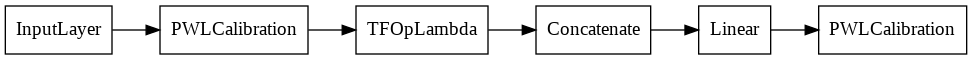

In [21]:
# Let's plot our model.
tf.keras.utils.plot_model(linear_model, 
                          show_layer_names=False, 
                          # show_shapes=True, 
                          rankdir='LR')

In [22]:
linear_model.compile(loss='mse',
             optimizer='adam',
             metrics=[tfa.metrics.RSquare()])

In [23]:
linear_model.evaluate(x, y)

4/4 [==============================] - 1s 3ms/step - loss: 4.6943 - r_square: -3.3336


[4.694312572479248, -3.333649158477783]

# Fitted model

In [24]:
%%time

EPOCHS = 100
BATCH_SIZE = 10

history = linear_model.fit(x, y,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 4.31 s, sys: 182 ms, total: 4.5 s
Wall time: 6.68 s


In [25]:
linear_model.evaluate(x, y)

4/4 [==============================] - 0s 5ms/step - loss: 0.2741 - r_square: 0.7470


[0.2740827202796936, 0.7469750046730042]

In [26]:
# linear_model.layers
input_layer = linear_model.layers[0]
calibration_layer = linear_model.layers[1]

calibration_model = tf.keras.Sequential([
            input_layer,
            calibration_layer
])

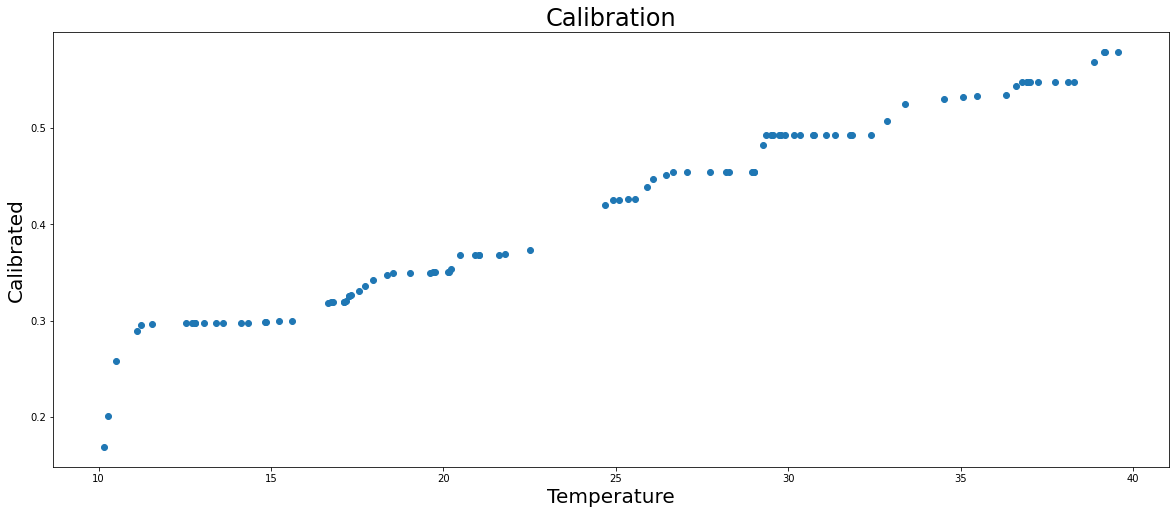

In [27]:
x_calibrated = calibration_model.predict(x)

plt.xlabel(x_label)
plt.ylabel('Calibrated')
plt.title('Calibration')

plt.scatter(x, x_calibrated);

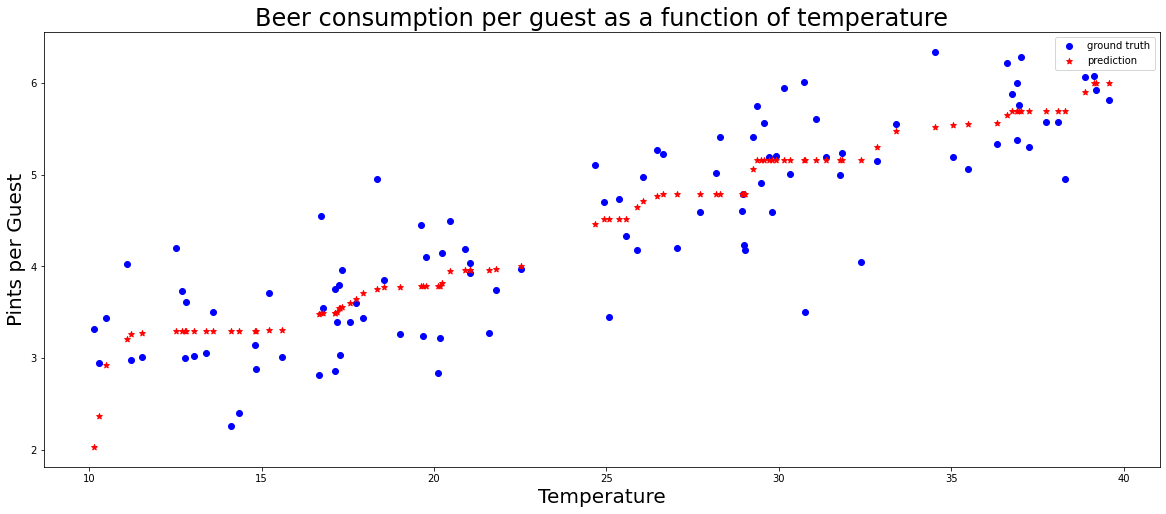

In [28]:
y_pred = linear_model.predict(x)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y, c='b');
plt.scatter(x, y_pred, c='r', marker='*');
plt.legend(['ground truth', 'prediction']);

# Extrapolation

In [29]:
x_extrapolated = np.linspace(0.0, 60.0, num=100)

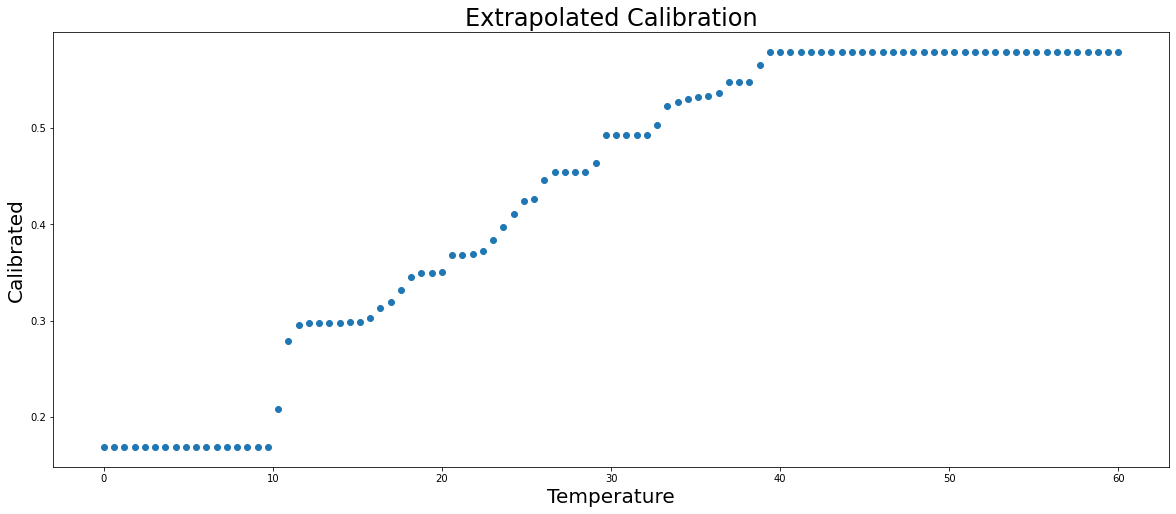

In [30]:
x_calibrated = calibration_model.predict(x_extrapolated)

plt.xlabel(x_label)
plt.ylabel('Calibrated')
plt.title('Extrapolated Calibration')

plt.scatter(x_extrapolated, x_calibrated);

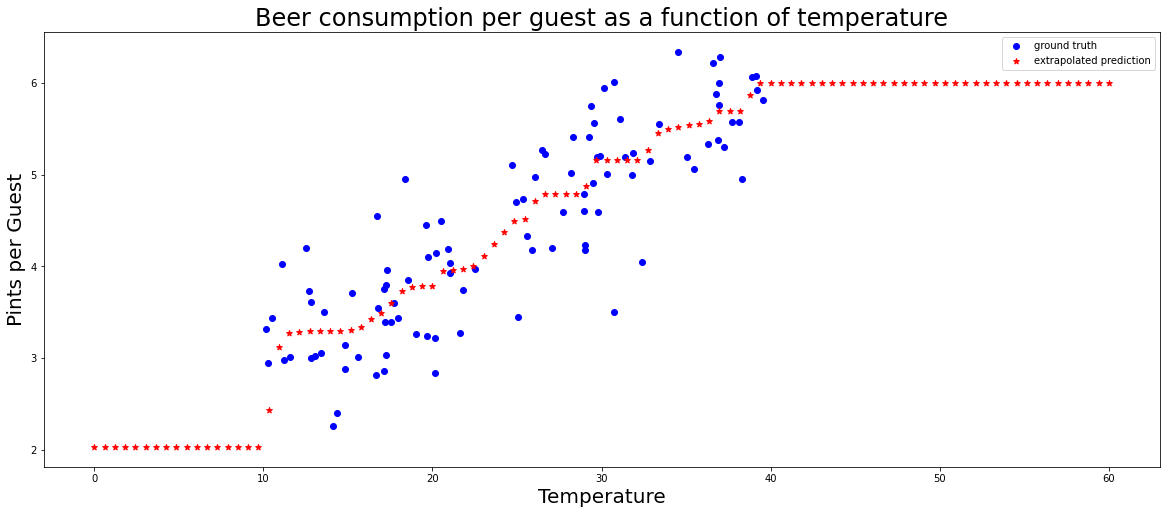

In [31]:
y_pred = linear_model.predict(x_extrapolated)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y, c='b');
plt.scatter(x_extrapolated, y_pred, c='r', marker='*');
plt.legend(['ground truth', 'extrapolated prediction']);

# This is just a TensorFlow graph (with all the benefits included)

In [32]:
linear_model.save('linear_model', save_format='tf')

INFO:tensorflow:Assets written to: linear_model/assets


In [33]:
!ls -l linear_model

total 132
drwxr-xr-x 2 root root   4096 Jun  6 15:11 assets
-rw-r--r-- 1 root root  23019 Jun  6 15:40 keras_metadata.pb
-rw-r--r-- 1 root root 101522 Jun  6 15:40 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun  6 15:40 variables


# From Calibration to Lattice

* this is just one feature
* calibration pretty much determines final prediction
* if we want to use two features, how would we combine calibrated features?

<img src='https://2.bp.blogspot.com/-1TTFfEsTZGM/Xj3EDMnP0nI/AAAAAAAACqU/MzUmff-fll4EMxj6JphYD-KJn8eaHdXngCLcBGAsYHQ/s1600/laticefunction.png'>

_A lattice is an interpolated look-up table that can approximate arbitrary input-output relationships in your data._

https://blog.tensorflow.org/2020/02/tensorflow-lattice-flexible-controlled-and-interpretable-ML.html

In [72]:
n = 100

noise_level = .6
noise = np.random.normal(0, noise_level, n)

title = 'Beer consumption per guest as a function of temperature'
x1_label = 'Temperature'
x2_label = 'Weight'
y_label = 'Pints per Guest'

# sort is not necessary, but makes x easier to understand
x1 = np.sort(np.random.uniform(10, 40, n))
l1 = 0.6
m1 = .1
b1 = 2
x2 = np.sort(np.random.uniform(40, 120, n))
l2 = 1 - l1
m2 = .07
b2 = 0

y = l1 * (m1*x1+b1) + l2 * (m2*x2+b2) + noise

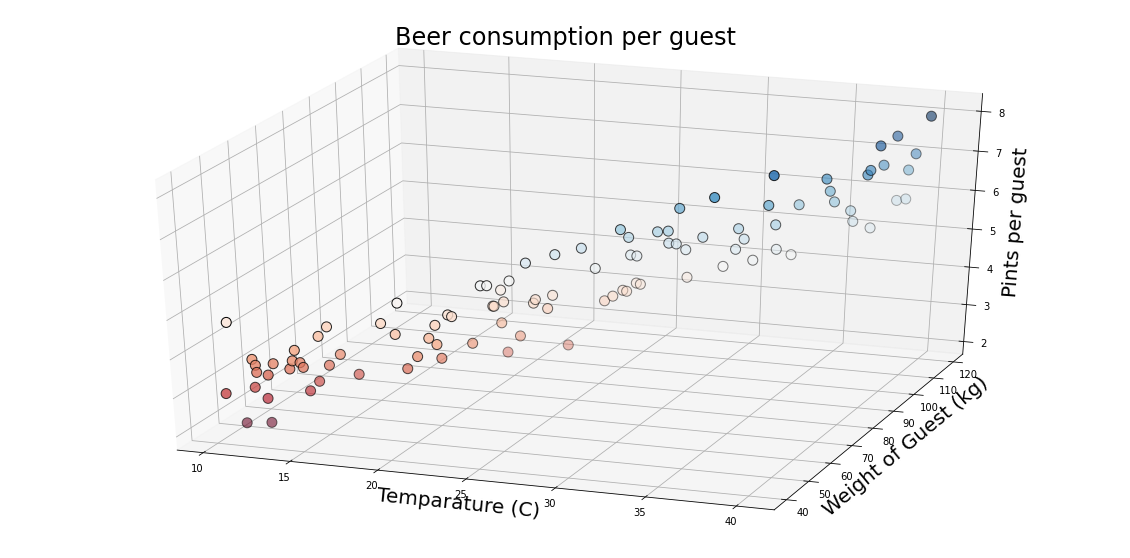

In [78]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Beer consumption per guest')
ax.set_xlabel('Temparature (C)')
ax.set_ylabel('Weight of Guest (kg)')
ax.set_zlabel('Pints per guest')

# we can have the probability encoded in shade of color
ax.scatter(x1, x2, y, 
           c=y, 
          #  cmap=cmap,
            cmap=plt.cm.RdBu,
          #  marker='o', 
           edgecolors='k',
           depthshade=True,
           s=100)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(azim=-70)
# ax.view_init(elev=5, azim=-45)